In [79]:
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
import gc
from utils import *
from tqdm import tqdm
import pickle

from tensorflow.keras.optimizers import *
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
# from tensorflow.keras.layers.core import *
# from tensorflow.keras.layers.convolutional import *
from tensorflow.keras import backend as K
import tensorflow.compat.v1 as tf

# Initialize the setting

In [80]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [85]:
random.seed(123)

class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 21 # the number of joints
        self.joint_d = 2 # the dimension of joints
        self.coarse = 12 # the number of classes
        self.feat_d = 210 # n(n-1)/2
        self.filters = 16
        self.data_dir = '..\\data\\JESTER\\'
C = Config()

# Building the model

In [86]:
def poses_diff(x):
    H, W = x.get_shape()[1],x.get_shape()[2]
    x = tf.subtract(x[:,1:,...],x[:,:-1,...])
    x = tf.image.resize_nearest_neighbor(x,size=[H,W],align_corners=False) # should not alignment here
    return x

def pose_motion(P,frame_l,joint_n,joint_d):
    P_diff_slow = Lambda(lambda x: poses_diff(x))(P)
    P_diff_slow = Reshape((frame_l,joint_n*joint_d))(P_diff_slow)
    P_fast = Lambda(lambda x: x[:,::2,...])(P)
    P_diff_fast = Lambda(lambda x: poses_diff(x))(P_fast)
    P_diff_fast = Reshape((int(frame_l/2),joint_n*joint_d))(P_diff_fast)
    return P_diff_slow,P_diff_fast
    
def c1D(x,filters,kernel):
    x = Conv1D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def block(x,filters):
    x = c1D(x,filters,3)
    x = c1D(x,filters,3)
    return x
    
def d1D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def build_FM(frame_l=32,joint_n=22,joint_d=2,feat_d=231,filters=16):   
    M = Input(shape=(frame_l,feat_d))
    P = Input(shape=(frame_l,joint_n,joint_d))
    
    diff_slow,diff_fast = pose_motion(P,frame_l,joint_n,joint_d)

    print("slow", diff_slow)
    print("fast", diff_fast)
    print("JCD", M)

    x = c1D(M,filters*2,1)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,3)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,1)
    x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x_d_slow = c1D(diff_slow,filters*2,1)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,3)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,1)
    x_d_slow = MaxPool1D(2)(x_d_slow)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)

    # 测试删去x_d_fast
    x_d_fast = c1D(diff_fast,filters*2,1)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,3) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,1) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
   
    x = concatenate([x,x_d_slow,x_d_fast]) # x = concatenate([x,x_d_slow,x_d_fast])
    print('concat', x.shape)
    x = block(x,filters*2)
    print('conv1', x.shape)
    x = MaxPool1D(2)(x)
    print('pool1', x.shape)
    x = SpatialDropout1D(0.1)(x)
    
    x = block(x,filters*4)
    print('conv2', x.shape)
    x = MaxPool1D(2)(x)
    print('pool2', x.shape)    
    x = SpatialDropout1D(0.1)(x)

    x = block(x,filters*8)
    print('conv3', x.shape)
    x = SpatialDropout1D(0.1)(x)
    
    return Model(inputs=[M,P],outputs=x)

In [87]:
def build_DD_Net(frame_l=32,joint_n=22,joint_d=3,feat_d=231,clc_num=14,filters=16):
    M = Input(name='M', shape=(frame_l,feat_d))  
    P = Input(name='P', shape=(frame_l,joint_n,joint_d)) 
    
    FM = build_FM(frame_l,joint_n,joint_d,feat_d,filters)
    
    x = FM([M,P])

    x = GlobalMaxPool1D()(x)
    print('pool', x.shape)    

    x = d1D(x,128)
    print('dense1', x.shape)    

    x = Dropout(0.5)(x)
    x = d1D(x,128)
    print('dense2', x.shape)    

    x = Dropout(0.3)(x)
    x = Dense(clc_num, activation='softmax')(x)
    print('dense3', x.shape)    

    ######################Self-supervised part
    model = Model(inputs=[M,P],outputs=x)
    return model

In [88]:
DD_Net = build_DD_Net(C.frame_l,C.joint_n,C.joint_d,C.feat_d,C.coarse,C.filters)

slow Tensor("reshape_6/Identity:0", shape=(None, 32, 42), dtype=float32)
fast Tensor("reshape_7/Identity:0", shape=(None, 16, 42), dtype=float32)
JCD Tensor("input_7:0", shape=(None, 32, 210), dtype=float32)
concat (None, 16, 48)
conv1 (None, 16, 32)
pool1 (None, 8, 32)
conv2 (None, 8, 64)
pool2 (None, 4, 64)
conv3 (None, 4, 128)
pool (None, 128)
dense1 (None, 128)
dense2 (None, 128)
dense3 (None, 12)


In [89]:
DD_Net.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
M (InputLayer)                  [(None, 32, 210)]    0                                            
__________________________________________________________________________________________________
P (InputLayer)                  [(None, 32, 21, 2)]  0                                            
__________________________________________________________________________________________________
model_6 (Model)                 (None, 4, 128)       117184      M[0][0]                          
                                                                 P[0][0]                          
__________________________________________________________________________________________________
global_max_pooling1d_3 (GlobalM (None, 128)          0           model_6[1][0]              

## load data

In [90]:
# 切换成无空帧数据
Train = pickle.load(open(C.data_dir+"train_gt20_1to6.pkl", "rb"))
Test = pickle.load(open(C.data_dir+"valid_gt20_1to6.pkl", "rb"))

## Without frame_sampling train

In [91]:
X_0 = []
X_1 = []
Y = []
for i in tqdm(range(len(Train['pose']))): 
    p = np.copy(Train['pose'][i]).reshape([-1,C.joint_n,C.joint_d])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range_2d(p)
    
    label = np.zeros(C.coarse)
    label[Train['label'][i]-1] = 1   

    M = get_CG(p,C)

    X_0.append(M)
    X_1.append(p)
    Y.append(label)

X_0 = np.stack(X_0)  
X_1 = np.stack(X_1) 
Y = np.stack(Y)

100%|███████████████████████████████████████████████████████████████████████████████| 258/258 [00:02<00:00, 126.84it/s]


In [93]:
print(X_0.shape, X_1.shape, Y.shape)

label = dict(zip(range(1,C.coarse+1),(0 for _ in range(C.coarse))))
for i in Y:
    for e in range(len(i)):
        if i[e] == 1:
            label[e+1] += 1
            break

print(label)

(258, 32, 210) (258, 32, 21, 2) (258, 12)
{1: 17, 2: 12, 3: 14, 4: 16, 5: 103, 6: 15, 7: 14, 8: 7, 9: 6, 10: 19, 11: 22, 12: 13}


In [94]:
X_test_0 = []
X_test_1 = []
Y_test = []
for i in tqdm(range(len(Test['pose']))): 
    p = np.copy(Test['pose'][i]).reshape([-1,C.joint_n,C.joint_d])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range_2d(p)
    
    label = np.zeros(C.coarse)
    label[Test['label'][i]-1] = 1   

    M = get_CG(p,C)

    X_test_0.append(M)
    X_test_1.append(p)
    Y_test.append(label)

X_test_0 = np.stack(X_test_0) 
X_test_1 = np.stack(X_test_1)  
Y_test = np.stack(Y_test)

100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 105.28it/s]


In [95]:
print(X_test_0.shape, X_test_1.shape, Y_test.shape)

label_test = dict(zip(range(1,C.coarse+1),(0 for _ in range(C.coarse))))
for i in Y_test:
    for e in range(len(i)):
        if i[e] == 1:
            label_test[e+1] += 1
            break

print(label_test)

(42, 32, 210) (42, 32, 21, 2) (42, 12)
{1: 2, 2: 0, 3: 1, 4: 3, 5: 15, 6: 2, 7: 1, 8: 0, 9: 1, 10: 3, 11: 10, 12: 4}


In [103]:
import tensorflow.keras
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=Adam(lr),metrics=['accuracy'])
lrScheduler = tensorflow.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=600,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test)      
                    )

Train on 258 samples, validate on 42 samples
Epoch 1/600
258/258 [==============================] - 9s 36ms/sample - loss: 0.5935 - accuracy: 0.7984 - val_loss: 0.6673 - val_accuracy: 0.8095
Epoch 2/600
258/258 [==============================] - 0s 1ms/sample - loss: 0.4777 - accuracy: 0.8488 - val_loss: 0.6359 - val_accuracy: 0.8333
Epoch 3/600
258/258 [==============================] - 0s 893us/sample - loss: 0.4481 - accuracy: 0.8682 - val_loss: 0.6682 - val_accuracy: 0.8333
Epoch 4/600
258/258 [==============================] - 0s 1ms/sample - loss: 0.5326 - accuracy: 0.8256 - val_loss: 0.6786 - val_accuracy: 0.8571
Epoch 5/600
258/258 [==============================] - 0s 850us/sample - loss: 0.5204 - accuracy: 0.8256 - val_loss: 0.6824 - val_accuracy: 0.8333
Epoch 6/600
258/258 [==============================] - 0s 982us/sample - loss: 0.4279 - accuracy: 0.8837 - val_loss: 0.6952 - val_accuracy: 0.8333
Epoch 7/600
258/258 [==============================] - 0s 1ms/sample - loss: 0

258/258 [==============================] - 0s 707us/sample - loss: 0.3522 - accuracy: 0.8915 - val_loss: 0.6445 - val_accuracy: 0.8095
Epoch 57/600
258/258 [==============================] - 0s 773us/sample - loss: 0.3199 - accuracy: 0.9070 - val_loss: 0.6439 - val_accuracy: 0.8095
Epoch 58/600
258/258 [==============================] - 0s 758us/sample - loss: 0.2999 - accuracy: 0.9031 - val_loss: 0.6438 - val_accuracy: 0.8095
Epoch 59/600
258/258 [==============================] - 0s 765us/sample - loss: 0.3499 - accuracy: 0.8798 - val_loss: 0.6433 - val_accuracy: 0.8095
Epoch 60/600
258/258 [==============================] - 0s 742us/sample - loss: 0.3062 - accuracy: 0.9264 - val_loss: 0.6429 - val_accuracy: 0.8095
Epoch 61/600
258/258 [==============================] - 0s 734us/sample - loss: 0.3301 - accuracy: 0.9264 - val_loss: 0.6429 - val_accuracy: 0.8095
Epoch 62/600
258/258 [==============================] - 0s 719us/sample - loss: 0.3183 - accuracy: 0.9109 - val_loss: 0.6426 

Epoch 112/600
258/258 [==============================] - 0s 758us/sample - loss: 0.3685 - accuracy: 0.8798 - val_loss: 0.6408 - val_accuracy: 0.8095
Epoch 113/600
258/258 [==============================] - 0s 711us/sample - loss: 0.3103 - accuracy: 0.9109 - val_loss: 0.6410 - val_accuracy: 0.8095
Epoch 114/600
258/258 [==============================] - 0s 765us/sample - loss: 0.2559 - accuracy: 0.9186 - val_loss: 0.6411 - val_accuracy: 0.8095
Epoch 115/600
258/258 [==============================] - 0s 680us/sample - loss: 0.3202 - accuracy: 0.8915 - val_loss: 0.6410 - val_accuracy: 0.8095
Epoch 116/600
258/258 [==============================] - 0s 773us/sample - loss: 0.3703 - accuracy: 0.8682 - val_loss: 0.6412 - val_accuracy: 0.8095
Epoch 117/600
258/258 [==============================] - 0s 820us/sample - loss: 0.3065 - accuracy: 0.9109 - val_loss: 0.6415 - val_accuracy: 0.8095
Epoch 118/600
258/258 [==============================] - 0s 727us/sample - loss: 0.3406 - accuracy: 0.8992

258/258 [==============================] - 0s 866us/sample


KeyboardInterrupt: 

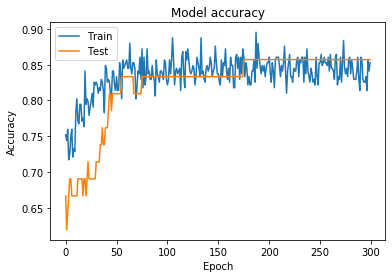

In [100]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [19]:
DD_Net.save_weights('weights/coarse_lite.h5')

OSError: Unable to create file (unable to open file: name = 'weights/coarse_lite.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 302)

## With frame_sampling

In [ ]:
lr = 1e-5
DD_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])

In [59]:
epochs = 20
for e in range(epochs):
    print('epoch{}'.format(e))
    X_0 = []
    X_1 = []
    Y = []
    
    for i in tqdm(range(len(Train['pose']))): 

        label = np.zeros(C.clc_coarse)
        label[Train['coarse_label'][i]-1] = 1 
        
        p = np.copy(Train['pose'][i]).reshape([-1,22,3])
        p = sampling_frame(p,C)
        
        M = get_CG(p,C)
        
        X_0.append(M)
        X_1.append(p)
        Y.append(label)

    X_0 = np.stack(X_0)  
    X_1 = np.stack(X_1) 
    Y = np.stack(Y)
   

    DD_Net.fit([X_0,X_1],Y,
            batch_size=len(Y),
            epochs=1,
            verbose=True,
            shuffle=True,
            validation_data=([X_test_0,X_test_1],Y_test)      
            )



epoch0


  0%|                                                                                          | 0/145 [00:00<?, ?it/s]


AttributeError: 'Config' object has no attribute 'clc_coarse'

# Calculate time (excute it twice, the first time initialize takes extra times)

In [44]:
import time
start_time = time.time()
y = DD_Net.predict([X_test_0,X_test_1])
time.time() - start_time

0.0947113037109375

In [45]:
# 看一下正确情况
result = []
result_dict = dict(zip(range(1,11),(0 for _ in range(10))))
for i in y:
#     print(i)
    max = 0
    for e in range(len(i)):
        if i[e] > i[max]:
            max = e
    result_dict[max+1] += 1
    result.append(max+1)


label = dict(zip(range(1,11),(0 for _ in range(10))))
label_list = []
for i in Y_test:
    for e in range(len(i)):
        if i[e] == 1:
            label[e+1] += 1
            label_list.append(e+1)
            break
            
print('predcit: ',result)
print('real:    ', label_list)

print('-------------分隔符----------')
print('predict: ',result_dict)
print('real:    ',label)


clscount = dict(zip(range(1,11),(0 for _ in range(10))))
for i in Y:
    for e in range(len(i)):
        if i[e] == 1:
            clscount[e+1] += 1
            break
print('-------------分隔符----------')
print(clscount)

predcit:  [5, 5, 6, 8, 5, 4, 5, 5, 8, 5, 1, 5, 5]
real:     [5, 5, 6, 6, 5, 4, 5, 5, 10, 5, 1, 5, 5]
-------------分隔符----------
predict:  {1: 1, 2: 0, 3: 0, 4: 1, 5: 8, 6: 1, 7: 0, 8: 2, 9: 0, 10: 0}
real:     {1: 1, 2: 0, 3: 0, 4: 1, 5: 8, 6: 2, 7: 0, 8: 0, 9: 0, 10: 1}
-------------分隔符----------
{1: 10, 2: 10, 3: 7, 4: 11, 5: 71, 6: 11, 7: 7, 8: 3, 9: 4, 10: 11}


In [102]:
# 用自己的数据实验
MySkel = pickle.load(open("C:\\Users\\zys98\\Desktop\\graduation\\github-repo\\sk_dd_2019\\codes\\data\\JESTER\\myskel.pkl", "rb"))

p = np.copy(MySkel)
p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
p = normlize_range_2d(p)
M = get_CG(p,C)

X_My_0 = []
X_My_0.append(p)
X_My_0 = np.stack(X_My_0)

X_My_1 = []
X_My_1.append(M)
X_My_1 = np.stack(X_My_1)

y = DD_Net.predict([X_My_1,X_My_0])
print(y)
max = 0
for i in range(len(y[0])):
    if y[0][i] > y[0][max]:
        max = i
print(max+1)

# X_0 = []
# X_1 = []
# Y = []
# for i in tqdm(range(len(Train['pose']))): 
#     p = np.copy(Train['pose'][i]).reshape([-1,C.joint_n,C.joint_d])
#     p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
#     p = normlize_range_2d(p)
    
#     label = np.zeros(C.coarse)
#     label[Train['label'][i]-1] = 1   

#     M = get_CG(p,C)

#     X_0.append(M)
#     X_1.append(p)
#     Y.append(label)

# X_0 = np.stack(X_0)  
# X_1 = np.stack(X_1) 
# Y = np.stack(Y)

[[0.5777253  0.00936834 0.04024233 0.03089608 0.0536707  0.01747629
  0.19982333 0.00402471 0.00865291 0.02756447 0.01311332 0.01744224]]
1


##### Plot confusion matrix

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

Y_pred = DD_Net.predict([X_test_0,X_test_1])
cnf_matrix = confusion_matrix(np.argmax(Y_test,axis=1),np.argmax(Y_pred,axis=1))
plt.figure(figsize=(10,10))
plt.imshow(cnf_matrix)
plt.show()